In [41]:
import os
import time
from dotenv import load_dotenv

from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf
from unstructured.partition.docx import partition_docx
from unstructured.cleaners.core import clean
from langchain.schema.document import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import TextLoader
from langchain_groq import ChatGroq
from langchain.memory import ConversationBufferMemory
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

from langchain.chains import LLMChain
from langchain import hub
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.vectorstores import Chroma
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings

load_dotenv()

True

# Load and and prepare PDF Data

In [2]:
# Import config
from utils.utils import read_config

partition_config = read_config(config_file=r"config.yml")["partitioning"]

In [42]:
pdf_path = "data/TISAX Participant Handbook.pdf"

# elements = partition_pdf(filename=pdf_path,
#                          extract_images_in_pdf=True,
#                          extract_image_block_output_dir="data/images",
#                          extract_image_block_to_payload = False,
#                          infer_table_structure= True,
#                          #chunking_strategy = "by_title"
#                          )

elements = partition_pdf(filename=pdf_path,
                         extract_images_in_pdf=False,
                         extract_image_block_output_dir="data/images",
                         extract_image_block_to_payload = False,
                         infer_table_structure= True,
                         chunking_strategy = "by_title"
                         )

In [30]:
# from langchain_community.document_loaders import UnstructuredPDFLoader

# loader = UnstructuredPDFLoader(pdf_path, mode="elements", strategy= "hi_res")
# data = loader.load()


In [4]:
print(len(elements))
print(set([el.category for el in elements]))
print(len([el for el in elements if el.category =="Image"]))
print(len([el for el in elements if el.category =="Table"]))
print(len([el for el in elements if el.category =="FigureCaption"]))
print(len([el for el in elements if el.category =="ListItem"]))
print(len([el for el in elements if el.category =="UncategorizedText"]))
print(len([el for el in elements if el.category =="Title"]))
print(len([el for el in elements if el.category =="NarrativeText"]))
print(len([el for el in elements if el.category =="CompositeElement"]))

620
{'CompositeElement', 'Table'}
0
56
0
0
0
0
0
564


In [43]:
comp_elemts = [el for el in elements if el.category =="CompositeElement"]
for el in comp_elemts:
    el.metadata.orig_elements = [e for e in el.metadata.orig_elements if e.category != "Image"]

In [44]:
print(comp_elemts[0].metadata.orig_elements)

[<unstructured.documents.elements.Title object at 0x318d90a40>, <unstructured.documents.elements.Title object at 0x318ee4830>, <unstructured.documents.elements.NarrativeText object at 0x318ee7f80>, <unstructured.documents.elements.NarrativeText object at 0x34101ee40>, <unstructured.documents.elements.NarrativeText object at 0x34101c3b0>, <unstructured.documents.elements.NarrativeText object at 0x34101f5f0>, <unstructured.documents.elements.NarrativeText object at 0x34101ec60>, <unstructured.documents.elements.NarrativeText object at 0x34101df70>, <unstructured.documents.elements.Title object at 0x34101c350>, <unstructured.documents.elements.NarrativeText object at 0x34101d370>, <unstructured.documents.elements.Title object at 0x34101d1f0>, <unstructured.documents.elements.NarrativeText object at 0x34101da90>]


In [45]:
# Keep all the text elemnts except Images -- Phase-1
# comp_elemts = [el for el in elements if el.category =="CompositeElement"]

# def partition_metadata(raw_elements, file_id=None,topic=None, category_id=None):
#         text_elements=[]
#         for element in raw_elements:
#             if element.category != "Image":                    
#                 if "unstructured.documents.elements.Table" in str(type(element)):
#                     metadata = {key:str(value) for key, value in element.metadata.to_dict().items()}
#                     metadata.update({'type':'table','file_id':file_id, 'category_id':category_id})
#                     ele = clean(element.metadata.text_as_html, extra_whitespace=True)
#                     text_elements.append(Document(page_content=ele,metadata=metadata))
#                 else:
#                     metadata = {key:str(value) for key, value in element.metadata.to_dict().items()}
#                     metadata.update({'type':'text','file_id':file_id,'category_id':category_id})
#                     text_elements.append(Document(page_content=str(element),metadata=metadata))
                
#         return text_elements

def partition_metadata(raw_elements, file_id=None,topic=None, category_id=None):
        text_elements=[]
        table_elements=[]
        for element in raw_elements:
            if "unstructured.documents.elements.CompositeElement" in str(type(element)):
                metadata = {key:str(value) for key, value in element.metadata.to_dict().items()}
                metadata.update({'type':'text','file_id':file_id,'category_id':category_id})
                text_elements.append(Document(page_content=str(element),metadata=metadata))
            elif "unstructured.documents.elements.Table" in str(type(element)):
                metadata = {key:str(value) for key, value in element.metadata.to_dict().items()}
                metadata.update({'type':'table','file_id':file_id, 'category_id':category_id})
                ele = clean(element.metadata.text_as_html, extra_whitespace=True)
                table_elements.append(Document(page_content=ele,metadata=metadata))
                
        return text_elements + table_elements

        

In [46]:
docs = partition_metadata(comp_elemts, file_id= "123",topic="TISAX", category_id= "12345")
print(docs[290].page_content)

If you “unfold” the ISA spider web to the question level, you get a similar green/red view on the question level:

TISAX Participant Handbook 2.7.2

Page 77 of 147

5. Assessment (Step 2)

QUESTION) 041254949 5 MATUR ty Levee @oo (ooo) @oo e@oo JOuk RESULT Soe= | YOU ARE READY May NOT BE SUPICIENT | FOR A TISAX FOR TISAX LABRS | ASSSSHENT

Figure 28. “Unfolding” the ISA spider web diagram


## Chunking

In [47]:
# Lets try with default chunking first

## Vector DB

In [48]:
from langchain_community.vectorstores import Chroma
import chromadb
import ollama
ollama.pull("nomic-embed-text")
from langchain_community.embeddings import OllamaEmbeddings


In [59]:
vectorstore = Chroma.from_documents(documents=docs, embedding=OllamaEmbeddings(model="nomic-embed-text"), collection_name="TISAX", persist_directory="./vectordb/")

In [61]:
from langchain_chroma import Chroma
vdb = Chroma(persist_directory="./vectordb/", collection_name="TISAX", embedding_function=OllamaEmbeddings(model="nomic-embed-text"))

## Call LLM

In [50]:
llm = ChatGroq(temperature=0, model_name=os.getenv("MODEL_NAME"), groq_api_key=os.getenv("GROQ_API_KEY"))

In [62]:
retriever = vdb.as_retriever()
# Load the Contextualize prompt from a file
with open(r'system_prompt.txt', 'r') as file:
    contextualize_q_system_prompt = file.read().strip()

contextualize_q_prompt = ChatPromptTemplate.from_messages([
SystemMessagePromptTemplate.from_template(contextualize_q_system_prompt),
MessagesPlaceholder(variable_name="chat_history"),
HumanMessagePromptTemplate.from_template("{input}")
])

history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)


### Answer question ###
qa_system_prompt = """You are a helpful assistant for Daimler truck cyber security department. You can answer the user query from the given context below:

{context}"""

qa_prompt = ChatPromptTemplate.from_messages([
    ("system", qa_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}")
    ])

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

### Statefully manage chat history ###
store = {}
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

conversational_rag_chain = RunnableWithMessageHistory(rag_chain, get_session_history, input_messages_key="input", history_messages_key="chat_history",output_messages_key="answer")


In [63]:
def process(text):
    start_time = time.time()

    # Go get the response from the LLM
    response = conversational_rag_chain.invoke({"input": text}, config={"configurable": {"session_id": "abc123"}})
    # response = self.conversation.invoke({"text": text})
    end_time = time.time()

    elapsed_time = int((end_time - start_time) * 1000)
    #print(f"LLM ({elapsed_time}ms): {response['answer']}")
    return response["answer"]

In [64]:
print(process("how can I enroll for TISAX?"))

To enroll for TISAX, you need to start with the registration process, which is the first step. Here's a general outline:

1. **Prepare for the online registration process**: Before you begin, make sure you have all the necessary information and documents ready.
2. **Go through the online registration process**: Follow the instructions provided in the TISAX Participant Handbook (Section 4, "Registration (Step 1)") to complete the online registration.
3. **Refer to additional resources if needed**: If you need more information or clarification, you can refer to Section 6, "Exchange (Step 3)" of the handbook.

Please note that the estimated reading time for the registration section is 30-40 minutes, so make sure you allocate sufficient time to complete the process.

If you have any specific questions or need further assistance, feel free to ask!


## Try to incorporate Image with vision models

In [37]:
# Extract page numbers where figure caption is mentioned
fig_pg_no = [el.metadata.page_number for el in elements if el.category =="FigureCaption"]

In [38]:
filterd_img_elemnts = [el for el in elements if (el.category=="Image") and (el.metadata.page_number in fig_pg_no)]

In [45]:
print(filterd_img_elemnts[7].metadata.image_base64)

None


In [113]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

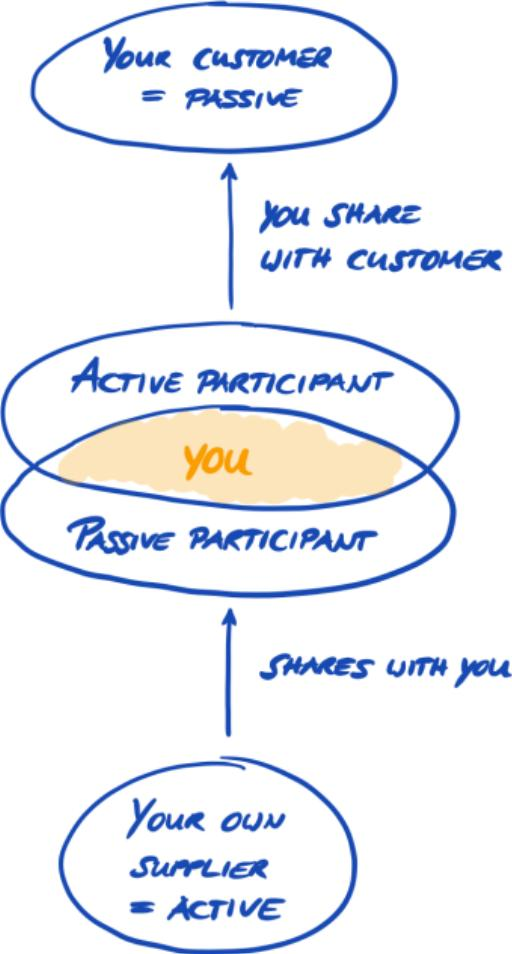

In [120]:
display_base64_image(filterd_img_elemnts[7].metadata.image_base64)